# Capstone 2 - Baseball Stat Projections - Pre-Processing

In [13]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.dummy import DummyRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
import statsmodels.api as sm 
import statsmodels.regression as smr

In [14]:
path = "/Users/joeboardman/Documents/Springboard/Capstone 2/data"
os.chdir(path)
df = pd.read_csv('Baseball_DW.csv', index_col=0)
dfmae = pd.read_csv('Baseball_DW.csv', index_col=0)
df.head()

,player_id,year,g,ab,r,h,double,triple,hr,rbi,...,g_2b_prev_2,g_3b_prev_2,g_ss_prev_2,g_of_prev_2,g_dh_prev_2,power,speed,contact,lucky_1,lucky_2
0,abbotku01,1996,109,320.0,37.0,81.0,18.0,7.0,8.0,33.0,...,0.0,0.0,107.0,0.0,0.0,0,0,0,0,1
1,abbotku01,1997,94,252.0,35.0,69.0,18.0,2.0,6.0,30.0,...,10.0,16.5,79.5,0.0,0.0,0,0,0,1,0
2,abbotku01,1999,96,286.0,41.0,78.0,17.0,2.0,8.0,41.0,...,37.0,18.5,25.5,5.0,0.0,0,0,0,1,1
3,abreubo01,2000,154,576.0,103.0,182.0,42.0,10.0,25.0,79.0,...,0.0,0.0,0.0,146.0,2.5,0,0,1,0,1
4,abreubo01,2001,162,588.0,118.0,170.0,48.0,4.0,31.0,110.0,...,0.0,0.0,0.0,149.0,2.5,0,0,1,0,0


In [15]:
# Remove current season counting stats to avoid data leakage
df = df.drop(['ops_vs_lg_avg', 'g', 'ab', 'r', 'h', 'double', 'triple', 'hr', 'rbi',
               'sb', 'cs', 'bb', 'so', 'ibb', 'hbp', 'sh', 'sf', 'g_idp', 'ops_vs_season_avg',
             'avg', 'bb%', 'k%', 'XBA%', 'hr%', 'iso', 'g_c','g_1b','g_2b','g_3b','g_ss',
              'g_of','g_dh','player_wOBA', 'wRAA', 'BABIP', 'lg_wOBA', 'season', 'allstar'], axis=1) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6062 entries, 0 to 6061
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     6062 non-null   object 
 1   year          6062 non-null   int64  
 2   salary        6062 non-null   int64  
 3   age           6062 non-null   int64  
 4   ops           6062 non-null   float64
 5   ops_lg        6062 non-null   float64
 6   season_ops    6062 non-null   float64
 7   lg_wOBAScale  6062 non-null   float64
 8   ops_1         6062 non-null   float64
 9   so_1          6062 non-null   float64
 10  allstar_1     6062 non-null   float64
 11  ops_2         6062 non-null   float64
 12  allstar_2     6062 non-null   float64
 13  ops_prev_2    6062 non-null   float64
 14  bb%_prev_2    6062 non-null   float64
 15  k%_prev_2     6062 non-null   float64
 16  XBA%_prev_2   6062 non-null   float64
 17  ab_prev_2     6062 non-null   float64
 18  avg_prev_2    6062 non-null 

In [16]:
# Break out response variable and scale data

X = df.drop(['player_id', 'ops'], axis=1)

y = df.ops

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)


In [17]:
# Split data into training and test splits

y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=34)


# Capstone 2 - Baseball Stat Projections - Modeling

### OPS vs last year's OPS Mean Absolute Error

In [18]:
mae_lastyr = mean_absolute_error(dfmae.ops, dfmae.ops_1)
print('Mean Absolute Average using OPS-1 vs OPS:', mae_lastyr)

Mean Absolute Average using OPS-1 vs OPS: 0.07570009897723523


### Model 1 - Linear Regression with all Features:

In [19]:
# Model 1 - Linear Regression

fit_start_time_linreg = time.time()

lin_reg = LinearRegression()
model_linreg = lin_reg.fit(X_train, y_train)

fit_end_time_linreg = time.time()

y_pred_linreg = model_linreg.predict(X_test)

# Evaluation Metrics
r2_linreg = r2_score(y_test, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

print('R-squared:',r2_linreg)
print('Mean Absolute Error:',mae_linreg)
print('Intercept:', abs(model_linreg.intercept_))
print(pd.DataFrame(abs(lin_reg.coef_), X.columns, columns=['Coefficient']).
      sort_values(by='Coefficient', ascending=False).head(10))

test_end_time_linreg = time.time()

fit_time_linreg = fit_end_time_linreg - fit_start_time_linreg
test_time_linreg = test_end_time_linreg - fit_end_time_linreg
print('Fit time:',fit_time_linreg, 'seconds')
print('Test time:',test_time_linreg, 'seconds')

metrics_linreg = ['Linear Regression', mae_linreg, r2_linreg, fit_time_linreg, test_time_linreg]
metrics_linreg

R-squared: 0.4653995474159558
Mean Absolute Error: 0.06304101137773194
Intercept: 0.7690562664529552
               Coefficient
ops_prev_2    2.452780e+12
ops_2         1.375319e+12
ops_1         1.374135e+12
g_of_prev_2   2.994750e-02
g_ss_prev_2   2.921507e-02
g_2b_prev_2   2.432804e-02
g_c_prev_2    2.282010e-02
g_3b_prev_2   2.009774e-02
lg_wOBAScale  1.725097e-02
age           1.710553e-02
Fit time: 0.013759136199951172 seconds
Test time: 0.008336067199707031 seconds


['Linear Regression',
 0.06304101137773194,
 0.4653995474159558,
 0.013759136199951172,
 0.008336067199707031]

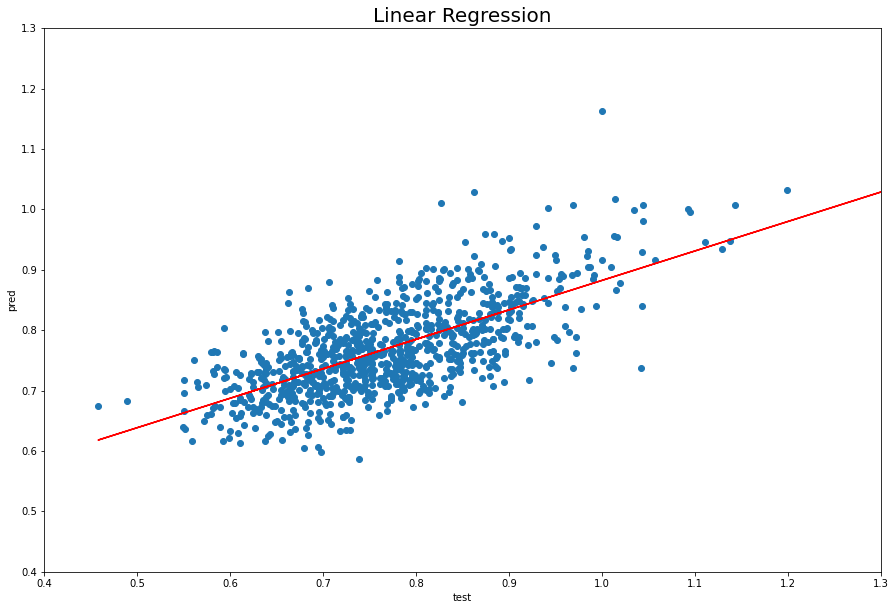

In [20]:
# Model 1 visual
plt.scatter(y_test, y_pred_linreg)
plt.rcParams["figure.figsize"] = (15,10)
m_linreg, p_linreg = np.polyfit(y_test, y_pred_linreg, 1)
plt.plot(y_test, m_linreg*y_test + p_linreg, color='red')
plt.title('Linear Regression', fontsize=20)
plt.xlim(0.4, 1.3)
plt.ylim(0.4, 1.3)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

### Model 2 - Gradient Boosting Model:

In [37]:
# Gradient Boosting Model

fit_start_time_gb = time.time()

gb = GradientBoostingRegressor(n_estimators=500, min_samples_split=10, min_samples_leaf=4, 
                                 max_features='auto', max_depth=15, learning_rate=0.01)
gb.fit(X_train, y_train)

fit_end_time_gb = time.time()

y_pred_gb = gb.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print('R-squared:',r2_gb)
print('Mean Absolute Error:',mae_gb)

test_end_time_gb = time.time()

fit_time_gb = fit_end_time_gb - fit_start_time_gb
test_time_gb = test_end_time_gb - fit_end_time_gb
print('Fit time:',fit_time_gb, 'seconds')
print('Test time:',test_time_gb, 'seconds')

metrics_gb = ['Gradient Boosting', mae_gb, r2_gb, fit_time_gb, test_time_gb]


R-squared: 0.3821390219385794
Mean Absolute Error: 0.06672323777605772
Fit time: 40.706209659576416 seconds
Test time: 0.060601234436035156 seconds


In [38]:
#scores = cross_val_score(gb, X_train, y_train, cv=5)
#print("Mean cross-validation score: %.2f" % scores.mean())

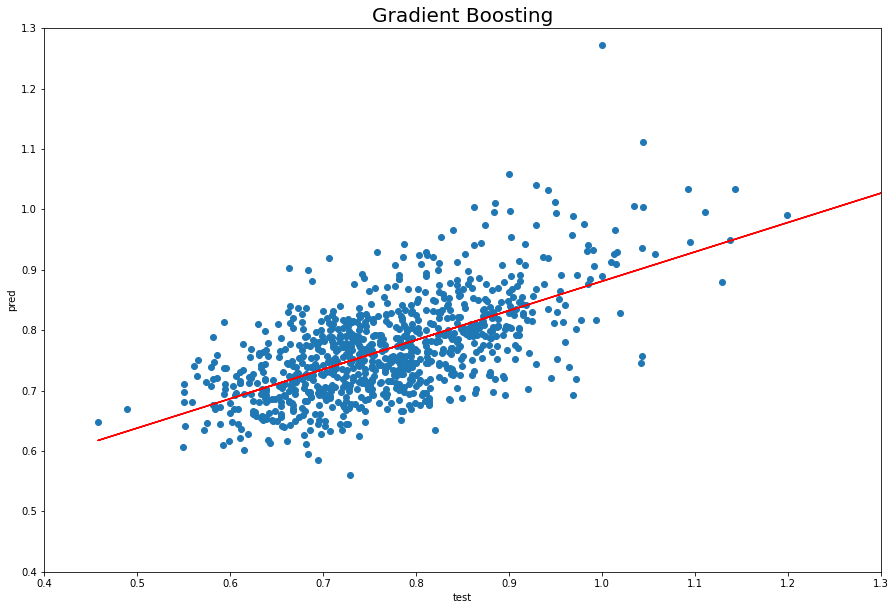

In [39]:
# Gradient Boosting Model visual
plt.scatter(y_test, y_pred_gb)
plt.rcParams["figure.figsize"] = (15,10)
m_gb, p_gb = np.polyfit(y_test, y_pred_gb, 1)
plt.plot(y_test, m_gb*y_test + p_gb, color='red')
plt.title('Gradient Boosting', fontsize=20)
plt.xlim(0.4, 1.3)
plt.ylim(0.4, 1.3)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

### Model 3 - Random Forest with All Features:

#### GridSearchCV on Model 3:

In [1952]:
# Random Forest GridSearch

start_time_GS_cv = time.time()

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5, 10, 15, 20, 30, 40, 50, 75, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 7, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'max_depth':max_depth,
             'max_features':max_features,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap}
rfr = RandomForestRegressor()
rfr_gs = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

rfr_gs.fit(X_train, y_train)

end_time_GS_cv = time.time()
print('Run time:',end_time_GS_cv - start_time_GS_cv, 'seconds')
print(rfr_gs.best_params_)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 52.2min finished


Run time: 3131.7296829223633 seconds
{'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}


In [1953]:
# Evaluation formula
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Run model with best parameters

rfr_gridsearch = rfr_gs.best_estimator_
rfr_gridsearch.fit(X_train, y_train)
gs_accuracy = evaluate(rfr_gridsearch, X_test, y_test)

Model Performance
Average Error: 0.0594 degrees.
Accuracy = 92.09%.


In [22]:
# Model 2 - Random Forest Regression

fit_start_time_rfr_all = time.time()

#rfr = RandomForestRegressor(n_estimators=100, random_state=34)
rfr = RandomForestRegressor(n_estimators=1000, bootstrap=True, max_depth=40, max_features='sqrt', 
                            min_samples_leaf=2, min_samples_split=10, random_state=34)
model_rfr_all = rfr.fit(X_train, y_train)

fit_end_time_rfr_all = time.time()

y_pred_rfr_all = model_rfr_all.predict(X_test)

# Evaluation Metrics
r2_rfr_all = r2_score(y_test, y_pred_rfr_all)
mae_rfr_all = mean_absolute_error(y_test, y_pred_rfr_all)

print('R-squared:',r2_rfr_all)
print('Mean Absolute Error:',mae_rfr_all)

test_end_time_rfr_all = time.time()

fit_time_rfr_all = fit_end_time_rfr_all - fit_start_time_rfr_all
test_time_rfr_all = test_end_time_rfr_all - fit_end_time_rfr_all
print('Fit time:',fit_time_rfr_all, 'seconds')
print('Test time:',test_time_rfr_all, 'seconds')

metrics_rfr_all = ['Random Forest Regression', mae_rfr_all, r2_rfr_all, fit_time_rfr_all, test_time_rfr_all]


R-squared: 0.4496549463021382
Mean Absolute Error: 0.06365231442567394
Fit time: 8.979810953140259 seconds
Test time: 0.17152690887451172 seconds


32


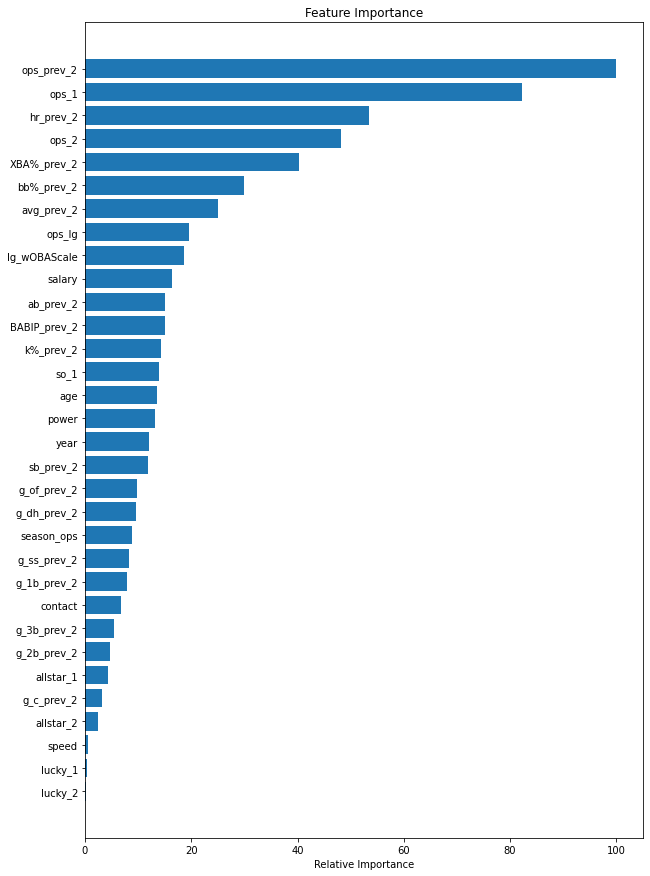

In [23]:
feature_importance_rfr_all = model_rfr_all.feature_importances_
# make importances relative to max importance
feature_importance_rfr_all = 100.0 * (feature_importance_rfr_all / feature_importance_rfr_all.max())
sorted_idx_rfr_all = np.argsort(feature_importance_rfr_all)

pos_rfr_all = np.arange(sorted_idx_rfr_all.shape[0]) + .5
print(pos_rfr_all.size)
sorted_idx_rfr_all.size
plt.figure(figsize=(10,15))
plt.barh(pos_rfr_all, feature_importance_rfr_all[sorted_idx_rfr_all], align='center')
plt.yticks(pos_rfr_all, X.columns[sorted_idx_rfr_all])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()
plt.close()

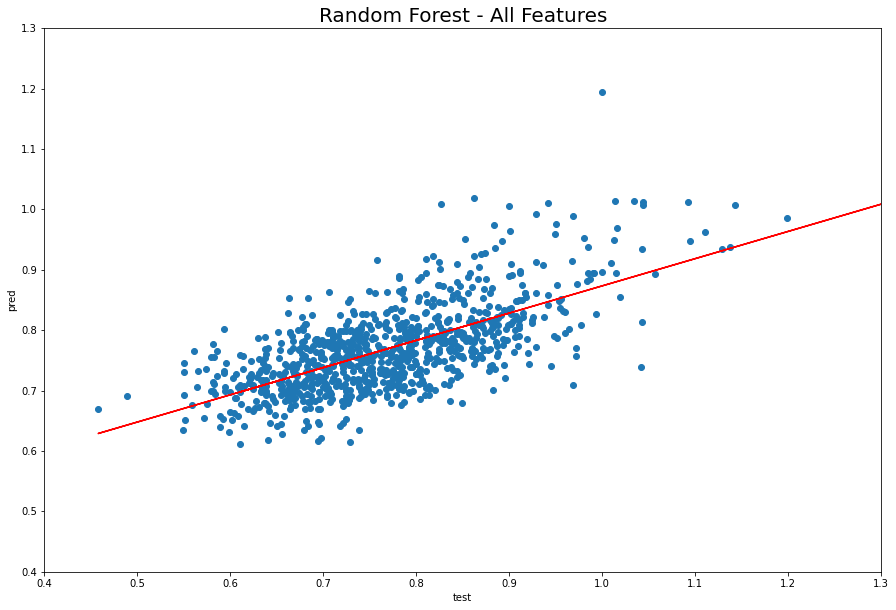

In [24]:
# Model 2 visual
plt.scatter(y_test, y_pred_rfr_all)
plt.rcParams["figure.figsize"] = (15,10)
m_rfr_all, p_rfr_all = np.polyfit(y_test, y_pred_rfr_all, 1)
plt.plot(y_test, m_rfr_all*y_test + p_rfr_all, color='red')
plt.title('Random Forest - All Features', fontsize=20)
plt.xlim(0.4, 1.3)
plt.ylim(0.4, 1.3)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

### Model 4 - Random Forest with Select Features:

In [32]:
# Model 4 - Run model with fewer, more important features

col_list = ['ops_prev_2', 'XBA%_prev_2', 'bb%_prev_2', 'avg_prev_2', 'salary']


#col_list = ['salary', 'age', 'year', 'season', 'wRAA_1', 'wRAA_2', 'bb%_1', 'bb%_2', 'k%_1', 'k%_2', 'XBA%_1',
#            'XBA%_2', 'hr%_1', 'hr%_2', 'BABIP_1', 'BABIP_2', 'g_c_1', 'g_1b_1', 'g_2b_1', 
#            'g_3b_1', 'g_ss_1', 'g_of_1','g_dh_1', 'ops_prev_2']

#col_list = ['salary', 'age', 'year', 'season', 'wRAA_1', 'bb%_1', 'k%_1', 'XBA%_1',
#            'hr%_1', 'iso_1', 'BABIP_1', 'g_c_1', 'g_1b_1', 'g_2b_1', 
#            'g_3b_1', 'g_ss_1', 'g_of_1','g_dh_1']#, 'wOBA_1', 'wOBA_2']

X4 = df[col_list]

y4 = df.ops

scaler4 = StandardScaler().fit(X4)

X_scaled4 = scaler4.transform(X4)

In [33]:
# Model 4 - split data into training and test sets

y4 = y4.ravel()

X_train_rfr_select, X_test_rfr_select, y_train_rfr_select, y_test_rfr_select = train_test_split(X_scaled4, y4, test_size=0.25, random_state=34)

In [34]:
# Model 4

fit_start_time_rfr_select = time.time()

rfr = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=10, min_samples_leaf=4, 
                            bootstrap=True, random_state=34)
#rfr = RandomForestRegressor(n_estimators=100, min_samples_split=10, min_samples_leaf=4, 
#                            max_features='auto', max_depth=15, bootstrap=True, random_state=34)
model_rfr_select = rfr.fit(X_train_rfr_select, y_train_rfr_select)

fit_end_time_rfr_select = time.time()

y_pred_rfr_select = model_rfr_select.predict(X_test_rfr_select)

# Evaluation Metrics
r2_rfr_select = r2_score(y_test_rfr_select, y_pred_rfr_select)
mae_rfr_select = mean_absolute_error(y_test_rfr_select, y_pred_rfr_select)

print('R-squared:',r2_rfr_select)
print('Mean Absolute Error:',mae_rfr_select)

test_end_time_rfr_select = time.time()

fit_time_rfr_select = fit_end_time_rfr_select - fit_start_time_rfr_select
test_time_rfr_select = test_end_time_rfr_select - fit_end_time_rfr_select
print('Fit time:',fit_time_rfr_select, 'seconds')
print('Test time:',test_time_rfr_select, 'seconds')

metrics_rfr_select = ['Random Forest Regression v2', mae_rfr_select, r2_rfr_select, fit_time_rfr_select, 
                      test_time_rfr_select]


R-squared: 0.42583146305547304
Mean Absolute Error: 0.0653152216501065
Fit time: 4.951718091964722 seconds
Test time: 0.08705687522888184 seconds


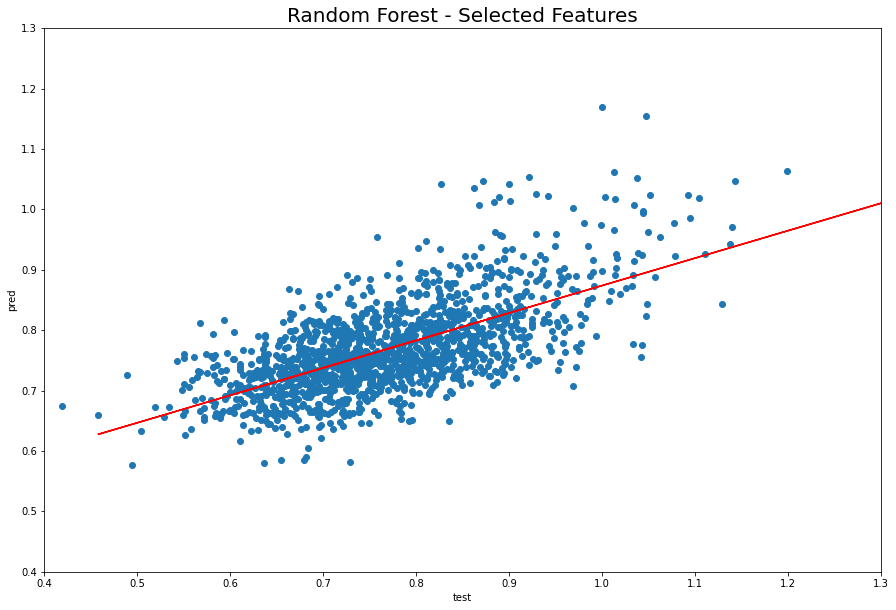

In [35]:
# Model 4 visual
plt.scatter(y_test_rfr_select, y_pred_rfr_select)
plt.rcParams["figure.figsize"] = (15,10)
m_rfr_select, p_rfr_select = np.polyfit(y_test_rfr_select, y_pred_rfr_select, 1)
plt.plot(y_test, m_rfr_select*y_test + p_rfr_select, color='red')
plt.title('Random Forest - Selected Features', fontsize=20)
plt.xlim(0.4, 1.3)
plt.ylim(0.4, 1.3)
plt.xlabel('test')
plt.ylabel('pred')
plt.show()
plt.close()

In [41]:
# Metrics Dataframe
cols = ['Model', 'MAE', 'R-squared', 'fit_time', 'test_time']

df_metrics = pd.DataFrame(data=[metrics_linreg, metrics_gb, metrics_rfr_all, 
                                metrics_rfr_select], columns=cols).set_index('Model')
df_metrics.round(decimals=4)


,MAE,R-squared,fit_time,test_time
Model,,,,
Linear Regression,0.0630,0.4654,0.0138,0.0083
Gradient Boosting,0.0667,0.3821,40.7062,0.0606
Random Forest Regression,0.0637,0.4497,8.9798,0.1715
Random Forest Regression v2,0.0653,0.4258,4.9517,0.0871
